# Clustering with K-means

compétences: c1 c2 c3 c4 c5 c20
Keywords: Unsupervised Learning, Clustering, Kmeans.

## Description

Découvrir l'apprentissage non-supervisé au travers de l'algorithme K-means.

## Contexte

L'apprentissage supervisé ce présente comme une approche de l'apprentissage automatique qui permet de découvrir la structure sous-jacente des données en l'absence d'étiquetage, c'est à dire sans catégories ou classe connue en avance.

Afin de se familiariser avec cette approche et mieux l'appréhender pour l'utiliser dans des scénario plus complexe, les objectifs sont les suivants : 
* Nous souhaitons comprendre le principe de cette technique et les scénarios d'utilisation
* Expérimenter et évaluer un algorithme de cet classe de problème d'apprentissage : les  K-moyennes (ou K-means) sur un jeu de données simple.
* Comprendre et comparer les métrique d'évaluation en jeux
* tester sur des jeux précédemment utilisé de classification, la capacité de l'algorithme à retrouver les catégories de prédiction.


Question de veilles:

Qu'est ce que le clustering ?
Est ce un probleme difficile ? pourquoi ?
* qu'elle est la compléxité d'un probléme de clustering ?
Quelle sont les métrique utilisé pour le clustering ?
* Ecriver en une phrase votre comprhéension pour chaque métrique découverte
* séparer les métrique avec "ground truth" et "sans "ground truth".
* différenc entre NMI et AMI ?

## Ressources

* https://le-datascientist.fr/apprentissage-supervise-vs-non-supervise
* https://realpython.com/k-means-clustering-python/#writing-your-first-k-means-clustering-code-in-python
* (fr) https://mrmint.fr/algorithme-k-means
* https://scikit-learn.org/stable/modules/clustering.html#clustering
* https://scikit-learn.org/stable/modules/clustering.html#clustering-evaluation
* https://dzone.com/articles/10-interesting-use-cases-for-the-k-means-algorithm



## Livrable

Un git par apprenant avec les éléments suivants:
1. Un notebook, résumant le travail

## Modalité pédagogique

durée: 2 jours
groupe: individuel


In [26]:
#Dieu 
import numpy as np
import pandas as pd
from time import time
#ploting
import matplotlib.pyplot as plt 
import seaborn as sns
#SK
from sklearn import metrics
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer , TfidfVectorizer , TfidfTransformer
from sklearn.datasets import load_digits
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from scipy.stats import mode
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
#NLP
import nltk
from nltk.corpus import stopwords , wordnet as wn
from nltk import wordpunct_tokenize , WordNetLemmatizer ,sent_tokenize ,  word_tokenize
from nltk.stem import PorterStemmer , LancasterStemmer
from nltk.stem.snowball import SnowballStemmer  


In [27]:
def bench_k_means(kmeans, name, data, labels):
    """Benchmark to evaluate the KMeans initialization methods.

    Parameters
    ----------
    kmeans : KMeans instance
        A :class:`~sklearn.cluster.KMeans` instance with the initialization
        already set.
    name : str
        Name given to the strategy. It will be used to show the results in a
        table.
    data : ndarray of shape (n_samples, n_features)
        The data to cluster.
    labels : ndarray of shape (n_samples,)
        The labels used to compute the clustering metrics which requires some
        supervision.
    """
    t0 = time()
    estimator = make_pipeline(StandardScaler(with_mean=False), kmeans).fit(data)
    fit_time = time() - t0
    results = [name, fit_time, estimator[-1].inertia_]

    # Define the metrics which require only the true labels and estimator
    # labels
    clustering_metrics = [
        metrics.homogeneity_score,
        metrics.completeness_score,
        metrics.v_measure_score,
        metrics.adjusted_rand_score,
        metrics.adjusted_mutual_info_score,
    ]
    results += [m(labels, estimator[-1].labels_) for m in clustering_metrics]

    # The silhouette score requires the full dataset
    results += [
        metrics.silhouette_score(data, estimator[-1].labels_,
                                 metric="euclidean")
    ]

    # Show the results
    formatter_result = ("{:9s}\t{:.3f}s\t{:.0f}\t{:.3f}\t{:.3f}"
                        "\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}")
    print(formatter_result.format(*results))

In [28]:
data, labels = load_digits(return_X_y=True)
(n_samples, n_features), n_digits = data.shape, np.unique(labels).size

print(f"# digits: {n_digits}; # samples: {n_samples}; # features {n_features}")

# digits: 10; # samples: 1797; # features 64


In [29]:
print(82 * '_')
print('init\t\ttime\tinertia\thomo\tcompl\tv-meas\tARI\tAMI\tsilhouette')

kmeans = KMeans(init="k-means++", n_clusters=n_digits, n_init=4,
                random_state=0)
bench_k_means(kmeans=kmeans, name="k-means++", data=data, labels=labels)

kmeans = KMeans(init="random", n_clusters=n_digits, n_init=4, random_state=0)
bench_k_means(kmeans=kmeans, name="random", data=data, labels=labels)

pca = PCA(n_components=n_digits).fit(data)
kmeans = KMeans(init=pca.components_, n_clusters=n_digits, n_init=1)
bench_k_means(kmeans=kmeans, name="PCA-based", data=data, labels=labels)

print(82 * '_')

__________________________________________________________________________________
init		time	inertia	homo	compl	v-meas	ARI	AMI	silhouette
k-means++	0.340s	69485	0.613	0.660	0.636	0.482	0.632	0.162
random   	0.082s	69952	0.545	0.616	0.578	0.415	0.574	0.137
PCA-based	0.023s	70849	0.538	0.649	0.588	0.422	0.584	0.123
__________________________________________________________________________________


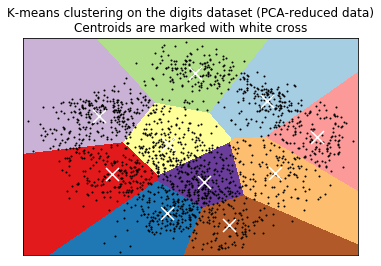

In [30]:
reduced_data = PCA(n_components=2).fit_transform(data)
kmeans = KMeans(init="k-means++", n_clusters=n_digits, n_init=4)
kmeans.fit(reduced_data)

# Step size of the mesh. Decrease to increase the quality of the VQ.
h = .02     # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(Z, interpolation="nearest",
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired, aspect="auto", origin="lower")

plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=2)
# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1], marker="x", s=169, linewidths=3,
            color="w", zorder=10)
plt.title("K-means clustering on the digits dataset (PCA-reduced data)\n"
          "Centroids are marked with white cross")
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()

In [31]:
digits = load_digits()
digits.data.shape

(1797, 64)

In [32]:
kmeans = KMeans(n_clusters=10, random_state=0)
clusters = kmeans.fit_predict(digits.data)
kmeans.cluster_centers_.shape

(10, 64)

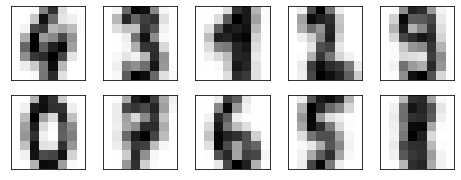

In [33]:
fig, ax = plt.subplots(2, 5, figsize=(8, 3))
centers = kmeans.cluster_centers_.reshape(10, 8, 8)
for axi, center in zip(ax.flat, centers):
    axi.set(xticks=[], yticks=[])
    axi.imshow(center, interpolation='nearest', cmap=plt.cm.binary)

In [34]:
labels = np.zeros_like(clusters)
accuracy_score(digits.target, labels)

0.09905397885364496

In [35]:
labels = np.zeros_like(clusters)
for i in range(10):
    mask = (clusters == i)
    labels[mask] = mode(digits.target[mask])[0]

In [36]:
accuracy_score(digits.target, labels)

0.7952142459654981

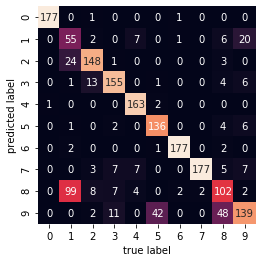

In [37]:
mat = confusion_matrix(digits.target, labels)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=digits.target_names,
            yticklabels=digits.target_names)
plt.xlabel('true label')
plt.ylabel('predicted label');

In [38]:
# Project the data: this step will take several seconds
tsne = TSNE(n_components=2, init='random', random_state=0)
digits_proj = tsne.fit_transform(digits.data)

# Compute the clusters
kmeans = KMeans(n_clusters=10, random_state=0)
clusters = kmeans.fit_predict(digits_proj)

# Permute the labels
labels = np.zeros_like(clusters)
for i in range(10):
    mask = (clusters == i)
    labels[mask] = mode(digits.target[mask])[0]

# Compute the accuracy
accuracy_score(digits.target, labels)

0.9371174179187535

 voici la mission que je vous propose pour cette après-midi : 

Nous souhaitons utiliser le clustering (et dont Kmeans) pour analyser les données texte annoté (émotions) en notre possessions et identifier les documents anormaux et obtenir des piste pour améliorer les résultats de classification.

En commençant par le premier jeux de donnée (le plus petit)

1. Est-que les clusters obtenue avec kmeans reflete les groupements de texte par émotions ?

No
2. comparer les résultats de plusieurs modéles dans un tableaux avec le temps, l'inertie, la NMI, la AMI, l'ARI Index et la silhouette.

3. quelle est le nombre de cluster optimal au regard de la métrique "silhouette" ? de l'inertie ?  est ce que l'inertie est corrélé à la mesure de silhouette ?

With the knowledge of previous project I obviously sarted with a equivalant number of cluster as number of emotion. Otherwise for the seconde dataset, I'm guessing that we would get better performance if we take lesser cluster than emotion instead we will some "shade of emotion". 

4. reproduire ces expériences avec le jeux de donnée 2.
I tried, fell on inconsistent data error, I had to erase the bloc for a cleaner book.

5. Peut-on identifier des cluster de documents ou des émotion difficile à classifier ? (ie cluster non homogéne)

J'imagine que vous avez quasiment répondu au point  5 déja ( ahaha nope ^^), je vous rajoute donc les question suivantes, maintenant que l'on sait que peux utiliser des outils de décomposition avec le texte :slight_smile:  : 
* Comment peut-on utiliser des methodes de decomposition (PCA like) pour améliorer la qualité du clustering ?
* Est ce que ces méthodes sont sensibles au centrage (standardScaler) ?
* a la vectorisation (CountVectorizer vs TfidfVectorizer ) ?
CountVectorizer + stop words seems more accurate in this case


In [39]:
df0 = pd.read_csv('../data/kaggle_emotion.csv')

corpus = np.array(df0['Text'])
targets = np.array(df0["Emotion"])
targets = np.array([1 if x == "sadness" else 2 if x=="anger" else 3 if x=="love" else 4 if x=="surprise" else 5 if x=="fear" 
else 6 for x in targets])

n_labels = np.unique(targets).size

count_vec = CountVectorizer(stop_words = 'english').fit_transform(corpus)
tf_vec = TfidfVectorizer(stop_words = 'english').fit_transform(corpus)

T_SVD = TruncatedSVD(n_components=n_labels).fit(tf_vec)


print(f"# Emotion_labels: {n_labels}")

# Emotion_labels: 6


In [40]:
print(82 * '_')
print('init\t\ttime\tinertia\thomo\tcompl\tv-meas\tARI\tAMI\tsilhouette')

kmeans = KMeans(init="k-means++", n_clusters=n_labels, n_init=6,random_state=0)
bench_k_means(kmeans=kmeans, name="k-means++", data=count_vec, labels=targets)

kmeans = KMeans(init="random", n_clusters=n_labels, n_init=6, random_state=0)
bench_k_means(kmeans=kmeans, name="random", data=count_vec, labels=targets)

T_SVD = TruncatedSVD(n_components=n_labels).fit(count_vec)
kmeans = KMeans(init=T_SVD.components_, n_clusters=n_labels, n_init=6)
bench_k_means(kmeans=kmeans, name="T_SVD", data=count_vec, labels=targets)

print(82 * '_')

__________________________________________________________________________________
init		time	inertia	homo	compl	v-meas	ARI	AMI	silhouette
k-means++	5.056s	405063112	0.000	0.137	0.000	-0.000	-0.000	0.139
random   	4.864s	405414921	0.002	0.110	0.004	-0.001	0.003	0.011
T_SVD    	3.937s	405531686	0.002	0.003	0.002	0.008	0.002	0.054
__________________________________________________________________________________


In [44]:
print(82 * '_')
print('init\t\ttime\tinertia\thomo\tcompl\tv-meas\tARI\tAMI\tsilhouette')

kmeans = KMeans(init="k-means++", n_clusters=n_labels, n_init=6,random_state=0)
bench_k_means(kmeans=kmeans, name="k-means++", data=tf_vec, labels=targets)

kmeans = KMeans(init="random", n_clusters=n_labels, n_init=6, random_state=0)
bench_k_means(kmeans=kmeans, name="random", data=tf_vec, labels=targets)

T_SVD = TruncatedSVD(n_components=n_labels).fit(tf_vec)
kmeans = KMeans(init=T_SVD.components_, n_clusters=n_labels, n_init=6)
bench_k_means(kmeans=kmeans, name="T_SVD", data=tf_vec, labels=targets)

print(82 * '_')

__________________________________________________________________________________
init		time	inertia	homo	compl	v-meas	ARI	AMI	silhouette
k-means++	3.399s	405305278	1.000	-0.000	-0.000	0.000	-0.000	-0.002
random   	5.011s	405605356	1.000	0.000	0.000	0.000	0.000	-0.007
T_SVD    	3.491s	405579534	1.000	0.000	0.000	0.000	0.000	-0.001
__________________________________________________________________________________


In [46]:
print(82 * '_')
print('init\t\ttime\tinertia\thomo\tcompl\tv-meas\tARI\tAMI\tsilhouette')

clf = TruncatedSVD(100)

count_pca = clf.fit_transform(count_vec)
count_pca_data = PCA(2).fit_transform(count_pca)
kmeans = KMeans(n_clusters=6, n_init=1)
bench_k_means(kmeans=kmeans, name="PCA-count_vec", data=count_pca_data, labels=targets)

tf_pca = clf.fit_transform(tf_vec) 
tf_pca_data = PCA(2).fit_transform(tf_pca)
bench_k_means(kmeans=kmeans, name="PCA-tf_vec", data=tf_pca_data, labels=targets)

print(82 * '_')

__________________________________________________________________________________
init		time	inertia	homo	compl	v-meas	ARI	AMI	silhouette
PCA-count_vec	0.038s	3817	1.000	0.000	0.000	0.000	0.000	0.784
PCA-tf_vec	0.053s	7420	1.000	0.000	0.000	0.000	0.000	0.544
__________________________________________________________________________________
